# ECSE415 Assignment 2
# Mai Zeng
# 260782174

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import segmentation, color
from skimage.future import graph
from skimage.segmentation import quickshift
import os
import math
from PIL import Image

## 1 Invariance of SIFT Features
### 1.1 Invariance Under Changes in Scale

In [29]:
# load image 
img = cv2.imread("book.jpg")
# copy image
img_disp = img.copy()
# convert to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_disp = cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB)

# 1. Compute SIFT keypoints for the reference image
# create a SIFT object
sift = cv2.xfeatures2d.SIFT_create() # replace with SURF_create() for SURF features

# detect SIFT features, with no masks
# 'None' is a mask but here is no masks so it is none
# Sometime we want to just compute the key points just in the mask
keypoints = sift.detect(img, None)

# draw the keypoints
cv2.drawKeypoints(img, keypoints, img_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# # display
# plt.figure(figsize=(20,20))
# plt.subplot(121), plt.imshow(img)
# plt.title("Original Book"), plt.xticks([]), plt.yticks([])
# plt.subplot(122), plt.imshow(img_disp)
# plt.title("SIFT Features Book"), plt.xticks([]), plt.yticks([])
# plt.show()

# num of SIFT keypoints
print('Num keypoints: '+ str(len(keypoints)))

Num keypoints: 385


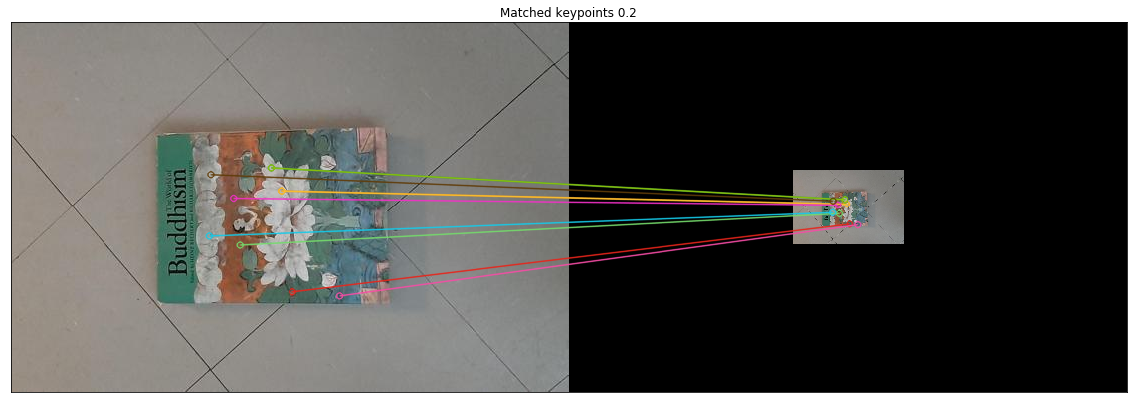

descriptors size: (385, 128)


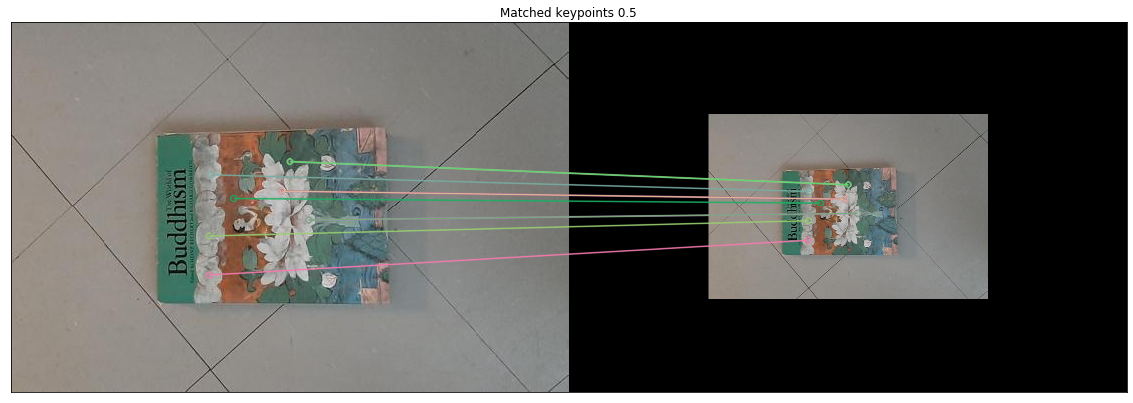

descriptors size: (385, 128)


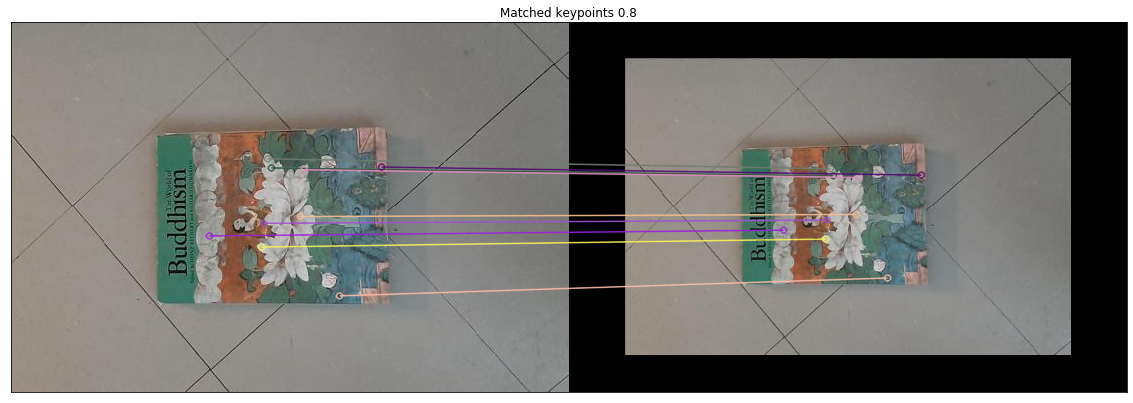

descriptors size: (385, 128)


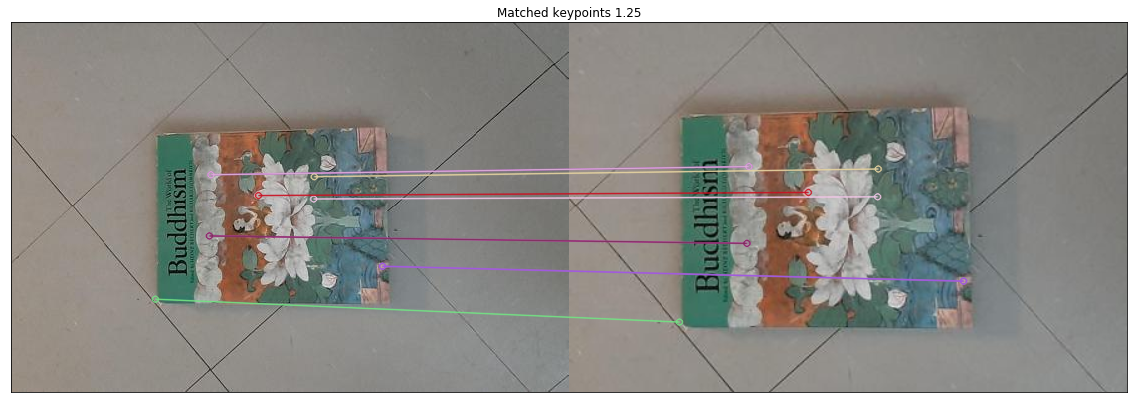

descriptors size: (385, 128)


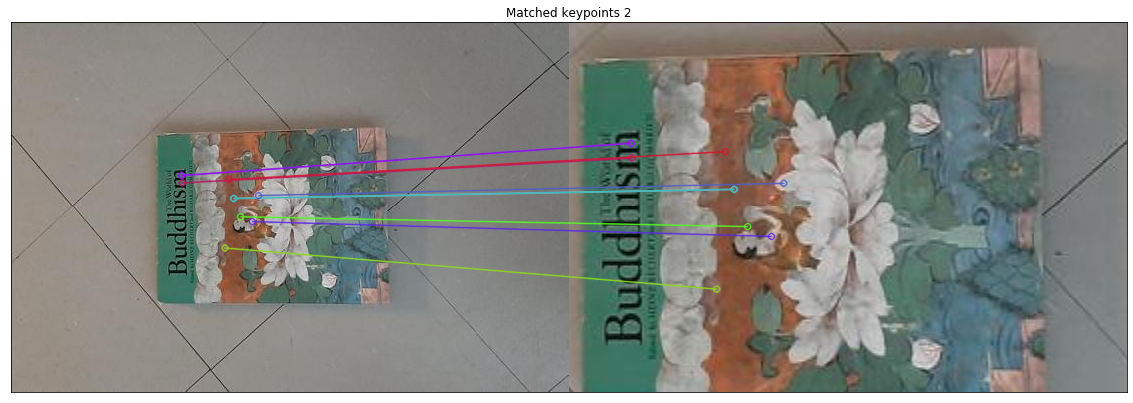

descriptors size: (385, 128)


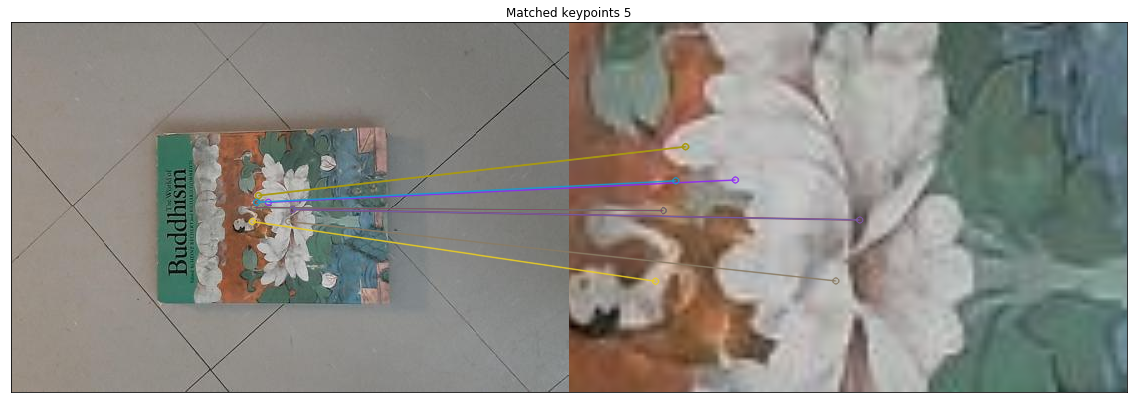

descriptors size: (385, 128)


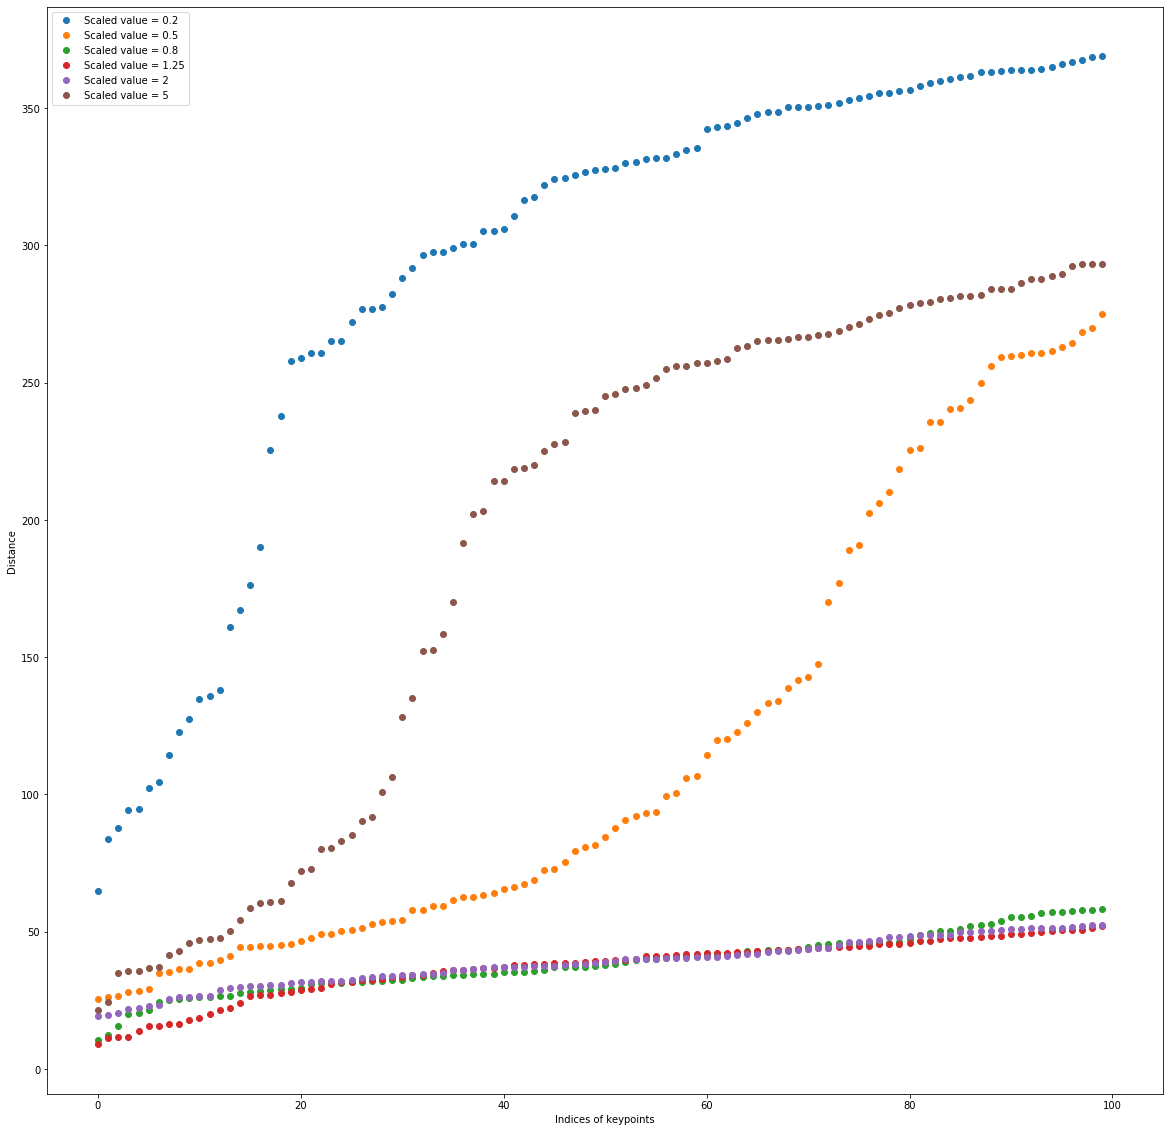

In [26]:
### 2. Scale reference image using scaling factors of (0.2, 0.5, 0.8, 1.25, 2, 5).
# load image 
img_book = cv2.imread("book.jpg")
# convert to RGB
img_book = cv2.cvtColor(img_book, cv2.COLOR_BGR2RGB)

# Get height and width in order
height, width = img_book.shape[0:2] # image size

scales = {0.2, 0.5, 0.8, 1.25, 2, 5}
img_book_scaled = {}

# 3. Compute SIFT keypoints for the transformed images
# create a SIFT object
sift = cv2.xfeatures2d.SIFT_create() # replace with SURF_create() for SURF features
title = "Matched keypoints {}"
img_relation_map = {}
for scale in sorted(scales):
    # Create a rotated, scaled duplicate
    # rotation marix around the center pixel, 0 degrees,scale of 0.2, 0.5, 0.8, 1.25, 2, 5
    # Actually get the pivot, so it not necessary is 1/2
    M_scaled = cv2.getRotationMatrix2D((width/2,height/2),0,scale)
    # Apply the transformation matrix
    # Why i need the size of the image: if I transform it (rotate it) the object is actually out of the image
    img_book_scaled[scale] = cv2.warpAffine(img_book,M_scaled,(width,height))
    # detect SIFT features, with no masks
    # 'None' is a mask but here is no masks so it is none
    # Sometime we want to just compute the key points just in the mask
    img_book_cpoy = img_book.copy()
    image_scaled_copy = img_book_scaled[scale].copy()
    keypoints,descriptors = sift.detectAndCompute(img_book_cpoy,None)
    keypoints_scaled,descriptors_scaled = sift.detectAndCompute(image_scaled_copy, None) 
    # create BFMatcher object
    # BF == brute force
    bf = cv2.BFMatcher()#cv2.NORM_HAMMING, crossCheck=True)
    # 4. Match all keypoints of the reference image to the transformed images using a brute-force method.
    # Match descriptors.
    # Match the first arguement to the second
    matches = bf.match(descriptors,descriptors_scaled) #query image, train image
    # 5. Sort matching keypoints according to the matching distance. (2 points)
    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)
    # 6. Display top ten matched keypoints for each pair of reference image and a transformed image.     
    # Draw first 10 matches.
    img_matches = cv2.drawMatches(img_book_cpoy,keypoints
                                  ,image_scaled_copy,keypoints_scaled, matches[:10], None, flags=2)
    plt.figure(figsize=(20,20))
    plt.imshow(img_matches)
    plt.title(title.format(scale)), plt.xticks([]), plt.yticks([])
    plt.show()
    
    # num of SIFT keypoints/descriptors
    print('descriptors size: '+ str(descriptors.shape))

#     for match in sorted(matches):
        # plot the 256x1 np array using matplotlib plot()
    x = []
    y = []
    i = 0
    for match in matches[:100]:
        x.append(i)
        y.append(match.distance)
        i = i + 1
        img_relation_map[scale] = (x,y)
#     plt.plot(x,y)
#     plt.ylabel("Distance")
#     plt.xlabel("Indices of keypoints")
#     plt.xlim([0,100]) # set x-axis limit
#     plt.title(title.format(scale)), plt.xticks([]), plt.yticks([])
#     plt.show()
plt.figure(figsize=(20,20))   
for scale in sorted(scales):
    x = img_relation_map[scale][0]
    y = img_relation_map[scale][1]
    plt.plot(x,y,'o',label = 'Scaled value = {}'.format(scale))
    plt.xlim([-5,105]) # set x-axis limit
plt.legend()
plt.ylabel("Distance")
plt.xlabel("Indices of keypoints")
plt.show()

#### 1.1.8. Discuss the trend in the plotted results. What is the effect of increasing the scale on the matching distance? Reason the cause.
As we can see if we scale by sizes 1.25, 2, or 0.8 they will give us similar trend with similar distance. But if we scale the image by a very large (5) or a very small size (0.2 or 0.8) it will give us a very large distance and a very different trend. The main reason is that the descriptor of SIFT is the neighor of the keypoint pixel. If we scale the image too much or too less then the neighbor pixel will change (e.g. it will from 1pixel -> 0.5 pixel) then it will have a lot of variance.

### 1.2 Invariance under Rotation

Num keypoints: 385
descriptors size: (385, 128)


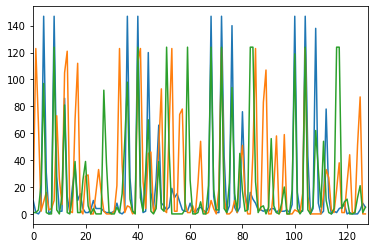

In [5]:
# load image 
img_book = cv2.imread("book.jpg")
# copy image
img_disp_book = img.copy()
# convert to RGB
img_book = cv2.cvtColor(img_book, cv2.COLOR_BGR2RGB)
img_disp = cv2.cvtColor(img_disp_book, cv2.COLOR_BGR2RGB)

# create a SIFT object
sift = cv2.xfeatures2d.SIFT_create() # replace with SURF_create() for SURF features

# 1. Compute SIFT keypoints for the reference image.

# compute SIFT descriptors
# Every row give you one key point
# Cant have multiple key points in one descriptors
# The row is the descriptor and column is the 
keypoints_origin, descriptors_origin = sift.compute(img_book, keypoints)
print('Num keypoints: '+ str(len(keypoints)))

# Alternatively, we can use keypoints,descriptors = sift.detectAndCompute(img) to get both

# num of SIFT keypoints/descriptors
print('descriptors size: '+ str(descriptors_origin.shape))

# # plot a couple of 1x128 SIFT descriptors
# num = 3
# for i in range(num):
#     # plot the 256x1 np array using matplotlib plot()
#     plt.plot(descriptors_origin[i])
#     plt.xlim([0,128]) # set x-axis limit
# plt.show()

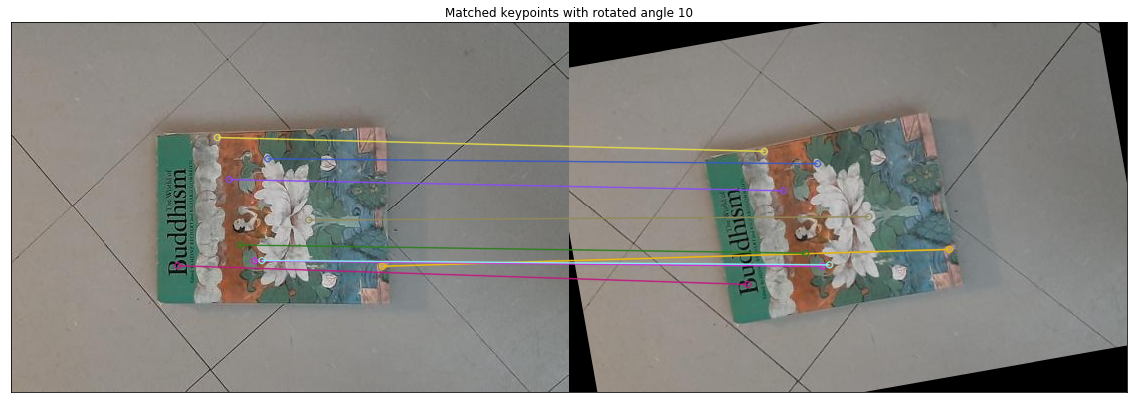

descriptors size: (385, 128)


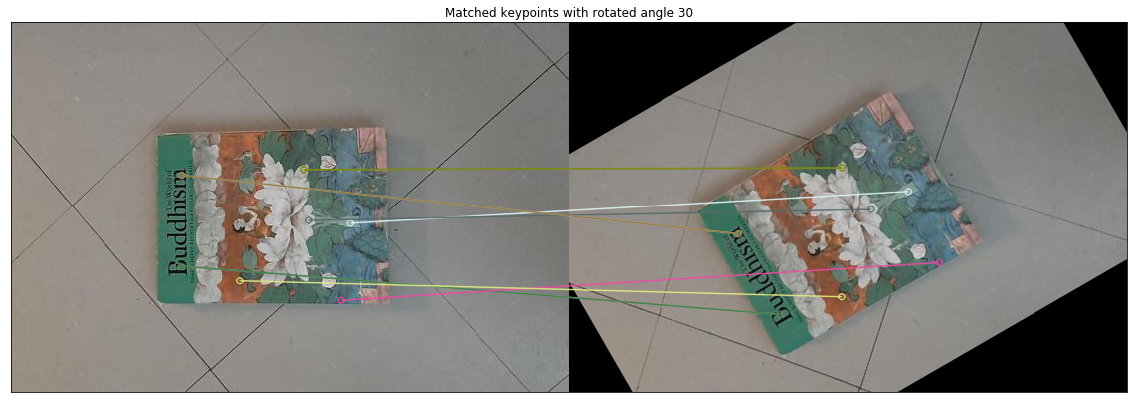

descriptors size: (385, 128)


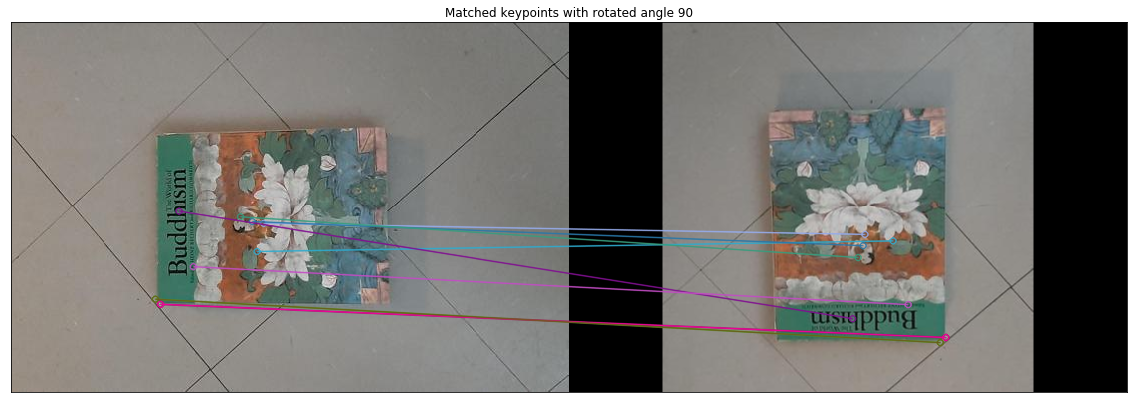

descriptors size: (385, 128)


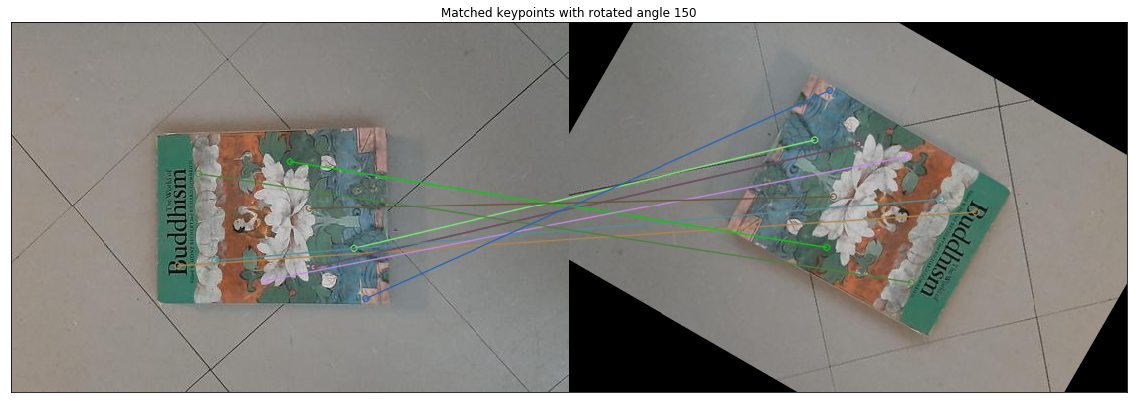

descriptors size: (385, 128)


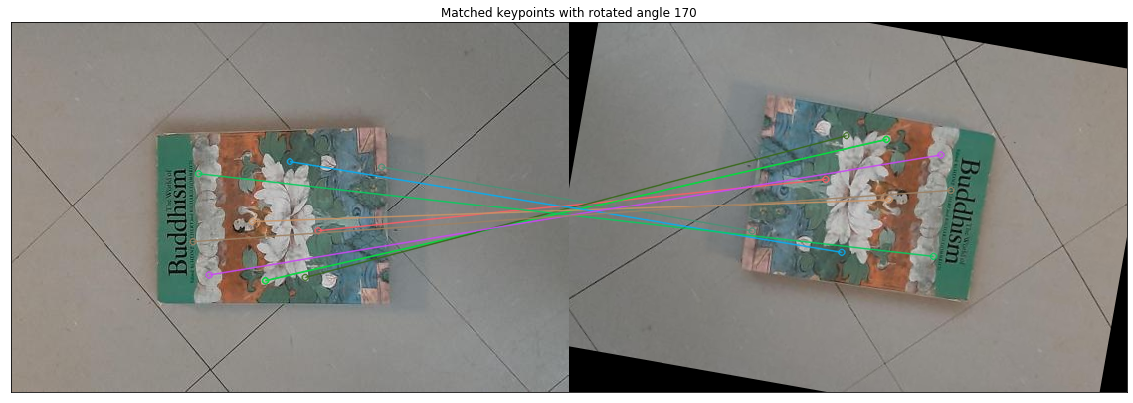

descriptors size: (385, 128)


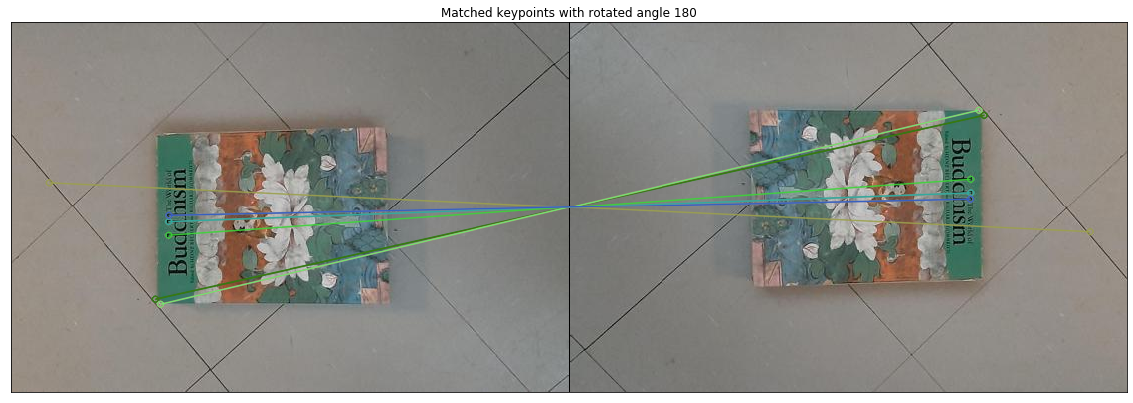

descriptors size: (385, 128)


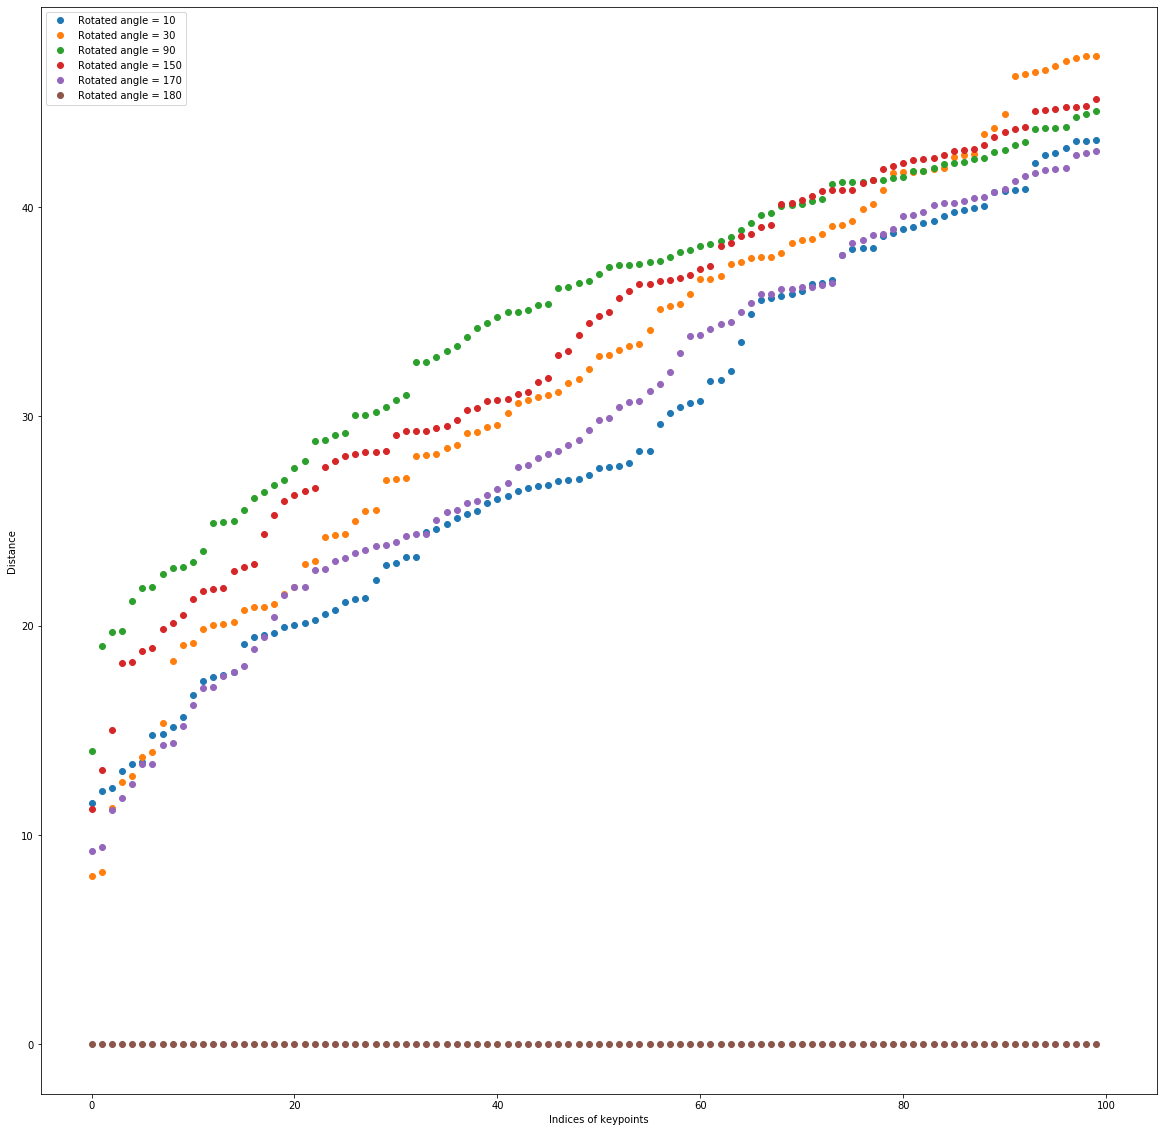

In [27]:
# load image 
img_book = cv2.imread("book.jpg")
# copy image
img_disp_book = img_book.copy()
# convert to RGB
img_book = cv2.cvtColor(img_book, cv2.COLOR_BGR2RGB)
img_disp = cv2.cvtColor(img_disp_book, cv2.COLOR_BGR2RGB)

height, width = img_book.shape[0:2] # image size

angles = {10,30,90,150,170,180}
image_book_rotated = {}

# create a SIFT object
sift = cv2.xfeatures2d.SIFT_create() # replace with SURF_create() for SURF features

title = "Matched keypoints with rotated angle {}"

img_relation_map = {}

# 2. Rotate reference image at the angle of (10,30,90,150,170,180) degrees.
for angle in sorted(angles):
    # Create a rotated, scaled duplicate
    # rotation marix around the center pixel, 10,30,90,150,170,180 degrees,scale of 1
    # Actually get the pivot, so it not necessary is 1/2
    M_rotated = cv2.getRotationMatrix2D((width/2,height/2),angle,1)
    # Apply the transformation matrix
    # Why i need the size of the image: if I transform it (rotate it) the object is actually out of the image
    image_book_rotated[angle] = cv2.warpAffine(img_book,M_rotated,(width,height))
    # detect SIFT features, with no masks
    # 'None' is a mask but here is no masks so it is none
    # Sometime we want to just compute the key points just in the mask
    img_book_cpoy = img_book.copy()
    image_rotated_copy = image_book_rotated[angle].copy()
    keypoints,descriptors = sift.detectAndCompute(img_book_cpoy,None)
    keypoints_rotated,descriptors_rotated = sift.detectAndCompute(image_rotated_copy, None) 
    # create BFMatcher object
    # BF == brute force
    bf = cv2.BFMatcher()#cv2.NORM_HAMMING, crossCheck=True)\
    # Match descriptors.
    # Match the first arguement to the second
    matches = bf.match(descriptors,descriptors_rotated) #query image, train image
    # 5. Sort matching keypoints according to the matching distance. (2 points)
    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)
    # 6. Display top ten matched keypoints for each pair of reference image and a transformed image.     
    # Draw first 10 matches.
    img_matches = cv2.drawMatches(img_book_cpoy,keypoints
                                  ,image_rotated_copy,keypoints_rotated, matches[:10], None, flags=2)
#     img_relation_map.append(image_matches)
    plt.figure(figsize=(20,20))
    plt.imshow(img_matches)
    plt.title(title.format(angle)), plt.xticks([]), plt.yticks([])
    plt.show()
    
        # num of SIFT keypoints/descriptors
    print('descriptors size: '+ str(descriptors.shape))
    x = []
    y = []
    i = 0
    for match in matches[:100]:
        x.append(i)
        y.append(match.distance)
        i = i + 1
    img_relation_map[angle] = (x,y)
plt.figure(figsize=(20,20))   
for angle in sorted(angles):
    x = img_relation_map[angle][0]
    y = img_relation_map[angle][1]
    plt.plot(x,y,'o', label = 'Rotated angle = {}'.format(angle))
    plt.xlim([-5,105]) # set x-axis limit
plt.legend()
plt.ylabel("Distance")
plt.xlabel("Indices of keypoints")
plt.show()

#### 1.2.8 Discuss the trend in the plotted results. What is the effect of increasing the angle of rotation on the matching distance? Reason the cause.
What I got from the brute force matcher (BFMatcher) is a DMatch object (an object list) and it contains all the match objects. The each match object has an attribute 'distance' and the lower the better. This means that if the value of the distnace is lower then the feature points are more similar.
The SIFT is to find the keypoint (interesting point) and the descripters are the 16x16 neighbors and by the descripters it will find the matches
As we can see in the picture, the rotation angles of 10, 170, 30, 150, 90 will give similar trends these mean that the SIFT will not variance by rotation. As for 180 degree it will just give a horizontal line it is because they are same picture but a fliped one so the neighbours are the same.